# Tree
Questo notebook serve per racchiudere quanto di utile per lo sviluppo di codice per valutare la scelta di alberi decisionali per il dataset scelto.

## Scaricamento dei dati

In [1]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip"]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_train.csv', 'dataset/y_train.csv']


## Estrazione dei dati

In [21]:
import pandas as pd

def load_data(x_path, y_path):
  """
  Loads X.csv and the second column of y.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X.csv file.
    y_path (str): The path to the y.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X.csv
                      and the second column of y.csv.
  """
  x = pd.read_csv(x_path)
  y = pd.read_csv(y_path)

  # Assuming y has at least 2 columns and the second column is at index 1
  if y.shape[1] > 1:
    combined_data = x.copy()
    combined_data['y_target'] = y.iloc[:, 1]
    return combined_data
  else:
    print("Error: y.csv does not have a second column.")
    return x

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

data = load_data(x_path, y_path)

# You can now work with the 'data' DataFrame
print(data.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Creazione training-set testing-set

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


## Cambio nome delle feature

In [12]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if not X:
                raise ValueError("Input tuple is empty.")
            df = X[0]
            rest = X[1:]
        else:
            df = X
            rest = ()

        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input (or first element if tuple) must be a DataFrame.")

        # Drop 'id' column if present
        if 'id' in df.columns:
            df = df.drop(columns='id')

        # Check column count matches
        if len(self.column_names) != df.shape[1]:
            if len(self.column_names) + 1 == df.shape[1] and 'faulty' in df.columns:
                print("Detected 'faulty' column, adjusting rename.")
                new_cols = self.column_names + ['faulty']
                if len(new_cols) != df.shape[1]:
                    raise ValueError("Mismatch in column count with 'faulty' included.")
                df_renamed = df.copy()
                df_renamed.columns = new_cols
            else:
                raise ValueError("Column count mismatch after dropping 'id'.")
        else:
            df_renamed = df.copy()
            df_renamed.columns = self.column_names

        return (df_renamed,) + rest if rest else df_renamed

# ---------------------- Setup ----------------------
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed', 'health_state'
]

# ---------------------- Pipeline ----------------------
pipeline_with_renaming = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data))
])

# Apply pipeline
data_train_renamed = pipeline_with_renaming.fit_transform(data_train)

# ---------------------- Output ----------------------
print("Renamed DataFrame (without 'id'):")
print(data_train_renamed.head())

Renamed DataFrame (without 'id'):
        torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067      74.8000            19.500       646.1000    1005.8400   
601458      67.0332            20.152       602.4063     958.4962   
77053       67.8000             8.000       546.7000      24.3840   
664037      53.9000             5.500       532.1000     360.8832   
346977      73.3000            17.750       636.3000    1025.9570   

        indicated_air_speed  net_power  compressor_speed  health_state  
331067             56.00000  100.19000          96.47000             1  
601458             96.97656   99.65235          94.02332             0  
77053              73.68750  100.22000          91.61000             0  
664037             61.87500   88.91000          99.78000             0  
346977             89.50000   99.98000          95.95000             1  


## Standardizzazione

In [24]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def _rename_df(self, df):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Each input must be a DataFrame.")

        df = df.drop(columns='id', errors='ignore')

        if len(self.column_names) != df.shape[1]:
            if 'faulty' in df.columns and len(self.column_names) + 1 == df.shape[1]:
                print("Detected 'faulty' column, adjusting rename.")
                df.columns = self.column_names + ['faulty']
            else:
                raise ValueError("Column count mismatch after dropping 'id'.")
        else:
            df.columns = self.column_names

        return df

    def transform(self, X):
        if isinstance(X, tuple):
            return tuple(self._rename_df(df) for df in X)
        else:
            return self._rename_df(X)


class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.target_column = None

    def fit(self, X, y=None):
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X
        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
            raise TypeError("Both elements must be pandas DataFrames.")

        self.target_column = data_train.columns[-1]
        self.feature_columns = data_train.columns[:-1]

        self.scaler.fit(data_train[self.feature_columns])
        return self

    def transform(self, X):
        data_train, data_test = X
        data_train_scaled = data_train.copy()
        data_test_scaled = data_test.copy()

        data_train_scaled[self.feature_columns] = self.scaler.transform(data_train[self.feature_columns])
        data_test_scaled[self.feature_columns] = self.scaler.transform(data_test[self.feature_columns])

        return (data_train_scaled, data_test_scaled)

# ---------------------- Example Usage ----------------------

# Example column names
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed', 'health_state'
]

data_test = data_train.copy()  # For simplicity

# Pipeline
pipeline_with_scaling = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler())
])

# Apply pipeline
scaled_data = pipeline_with_scaling.fit_transform((data_train, data_test))

# Output
print("\nScaled and Split Data:")
print("Train shape:", scaled_data[0].shape)
print("Test shape:", scaled_data[1].shape)
print("Sample scaled train data:\n", scaled_data[0].head())



Scaled and Split Data:
Train shape: (594100, 8)
Test shape: (594100, 8)
Sample scaled train data:
         torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067     0.731935          0.845806       1.357989     0.877700   
601458     0.145607          0.926646       0.255597     0.793633   
77053      0.203494         -0.580045      -1.149874    -0.865050   
664037    -0.845839         -0.890013      -1.518232    -0.267535   
346977     0.618698          0.628829       1.110735     0.913422   

        indicated_air_speed  net_power  compressor_speed  health_state  
331067            -0.659161   0.703895          0.261704             1  
601458             0.498516   0.569311         -0.411386             0  
77053             -0.159451   0.711405         -1.075299             0  
664037            -0.493179  -2.119706          1.172296             0  
346977             0.287287   0.651328          0.118650             1  


## Decision tree prima esecuzione

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def _rename_df(self, df):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Each input must be a DataFrame.")

        df = df.drop(columns='id', errors='ignore')

        if len(self.column_names) != df.shape[1]:
            if 'faulty' in df.columns and len(self.column_names) + 1 == df.shape[1]:
                print("Detected 'faulty' column, adjusting rename.")
                df.columns = self.column_names + ['faulty']
            else:
                raise ValueError("Column count mismatch after dropping 'id'.")
        else:
            df.columns = self.column_names

        return df

    def transform(self, X):
        if isinstance(X, tuple):
            return tuple(self._rename_df(df) for df in X)
        else:
            return self._rename_df(X)


class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.target_column = None

    def fit(self, X, y=None):
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X
        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
            raise TypeError("Both elements must be pandas DataFrames.")

        self.target_column = data_train.columns[-1]
        self.feature_columns = data_train.columns[:-1]

        self.scaler.fit(data_train[self.feature_columns])
        return self

    def transform(self, X):
        data_train, data_test = X
        data_train_scaled = data_train.copy()
        data_test_scaled = data_test.copy()

        data_train_scaled[self.feature_columns] = self.scaler.transform(data_train[self.feature_columns])
        data_test_scaled[self.feature_columns] = self.scaler.transform(data_test[self.feature_columns])

        return (data_train_scaled, data_test_scaled)

class DecisionTreeTrainer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to train a Decision Tree Classifier model.

    Assumes the input is a tuple (data_train, data_test) as pandas DataFrames,
    where the last column is the target variable and the rest are features.
    It fits the model only on the training data.
    """
    def __init__(self):
        # Initialize the Decision Tree Classifier with Gini criterion
        self.model = DecisionTreeClassifier(criterion="gini", random_state=42)

    def fit(self, X, y=None):
        """
        Fits the Decision Tree Classifier model on the training data.

        Args:
            X: A tuple (data_train, data_test) where data_train and data_test
               are pandas DataFrames. The last column is assumed to be the target.
            y: Target data (ignored, as the target is expected in data_train).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X

        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
             raise TypeError("Both elements in the input tuple must be pandas DataFrames.")

        # Separate features (X_train) and target (y_train) from data_train
        X_train = data_train.iloc[:, :-1]
        y_train = data_train.iloc[:, -1]

        print(f"Training Decision Tree Classifier with criterion='{self.model.criterion}'...")
        # Fit the model on the training data
        self.model.fit(X_train, y_train)
        print("Decision Tree model training complete.")

        return self

    def transform(self, X):
        """
        Returns the trained model and the scaled data (train and test).

        Args:
            X: A tuple (data_train, data_test) (ignored, model is trained in fit).

        Returns:
            tuple: A tuple containing (trained_model, scaled_data_train, scaled_data_test).
                   Note: This structure is an example. You might adjust
                   what transform returns based on the next pipeline step.
                   Returning the model here allows access to it after the pipeline runs.
                   Returning the scaled data allows for prediction in subsequent steps.
        """
        if self.model is None:
             raise RuntimeError("Model has not been trained yet. Call fit() first.")

        # Return the trained model and the scaled data
        # Assuming the input X is the output of the previous step (DataScaler)
        scaled_data_train, scaled_data_test = X

        return (self.model, scaled_data_train, scaled_data_test)


# ---------------------- Example Usage ----------------------

# Example column names
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed', 'health_state'
]

data_test = data_train.copy()  # For simplicity

# Pipeline
pipeline_with_decision_tree = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer()) # Add the Decision Tree Trainer
])

# Apply pipeline
trained_model = pipeline_with_decision_tree.fit_transform((data_train, data_test))

# Output
print("\nDecision Tree Pipeline Execution Complete.")
print("Trained Decision Tree Model:", trained_model)

Training Decision Tree Classifier with criterion='gini'...
Decision Tree model training complete.

Decision Tree Pipeline Execution Complete.
Trained Decision Tree Model: (DecisionTreeClassifier(random_state=42),         torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067     0.731935          0.845806       1.357989     0.877700   
601458     0.145607          0.926646       0.255597     0.793633   
77053      0.203494         -0.580045      -1.149874    -0.865050   
664037    -0.845839         -0.890013      -1.518232    -0.267535   
346977     0.618698          0.628829       1.110735     0.913422   
...             ...               ...            ...          ...   
259178    -0.664659          1.527735      -0.408111    -0.677244   
365838    -0.189062         -1.137987      -0.090213    -0.758428   
131932     1.237729         -1.230977       1.668318    -0.277277   
671155    -0.429721         -1.166401       0.023796     3.025799   
121958     2.128529         

## K-fold

In [29]:
# prompt: vorrei aggiungessi alla pipeline una validazione su data_train con un 5-fold, di scoring non mettere ancora nulla, lo aggiungerei poi

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def _rename_df(self, df):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Each input must be a DataFrame.")

        df = df.drop(columns='id', errors='ignore')

        if len(self.column_names) != df.shape[1]:
            if 'faulty' in df.columns and len(self.column_names) + 1 == df.shape[1]:
                print("Detected 'faulty' column, adjusting rename.")
                df.columns = self.column_names + ['faulty']
            else:
                raise ValueError("Column count mismatch after dropping 'id'.")
        else:
            df.columns = self.column_names

        return df

    def transform(self, X):
        if isinstance(X, tuple):
            return tuple(self._rename_df(df) for df in X)
        else:
            return self._rename_df(X)


class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.target_column = None

    def fit(self, X, y=None):
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X
        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
            raise TypeError("Both elements must be pandas DataFrames.")

        self.target_column = data_train.columns[-1]
        self.feature_columns = data_train.columns[:-1]

        self.scaler.fit(data_train[self.feature_columns])
        return self

    def transform(self, X):
        data_train, data_test = X
        data_train_scaled = data_train.copy()
        data_test_scaled = data_test.copy()

        data_train_scaled[self.feature_columns] = self.scaler.transform(data_train[self.feature_columns])
        data_test_scaled[self.feature_columns] = self.scaler.transform(data_test[self.feature_columns])

        return (data_train_scaled, data_test_scaled)

class DecisionTreeTrainer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to train a Decision Tree Classifier model.

    Assumes the input is a tuple (data_train, data_test) as pandas DataFrames,
    where the last column is the target variable and the rest are features.
    It fits the model only on the training data.
    """
    def __init__(self):
        # Initialize the Decision Tree Classifier with Gini criterion
        self.model = DecisionTreeClassifier(criterion="gini", random_state=42)

    def fit(self, X, y=None):
        """
        Fits the Decision Tree Classifier model on the training data.

        Args:
            X: A tuple (data_train, data_test) where data_train and data_test
               are pandas DataFrames. The last column is assumed to be the target.
            y: Target data (ignored, as the target is expected in data_train).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X

        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
             raise TypeError("Both elements in the input tuple must be pandas DataFrames.")

        # Separate features (X_train) and target (y_train) from data_train
        X_train = data_train.iloc[:, :-1]
        y_train = data_train.iloc[:, -1]

        print(f"Training Decision Tree Classifier with criterion='{self.model.criterion}'...")
        # Fit the model on the training data
        self.model.fit(X_train, y_train)
        print("Decision Tree model training complete.")

        return self

    def transform(self, X):
        """
        Returns the trained model and the scaled data (train and test).

        Args:
            X: A tuple (data_train, data_test) (ignored, model is trained in fit).

        Returns:
            tuple: A tuple containing (trained_model, scaled_data_train, scaled_data_test).
                   Note: This structure is an example. You might adjust
                   what transform returns based on the next pipeline step.
                   Returning the model here allows access to it after the pipeline runs.
                   Returning the scaled data allows for prediction in subsequent steps.
        """
        if self.model is None:
             raise RuntimeError("Model has not been trained yet. Call fit() first.")

        # Return the trained model and the scaled data
        # Assuming the input X is the output of the previous step (DataScaler)
        scaled_data_train, scaled_data_test = X

        return (self.model, scaled_data_train, scaled_data_test)

class DecisionTreeCrossValidator(BaseEstimator, TransformerMixin):
    """
    A custom transformer to perform K-Fold Cross-Validation on a Decision Tree Classifier.

    Assumes the input is a tuple containing (trained_model, data_train, data_test).
    It performs cross-validation on the training data (data_train) using the
    provided model.
    """
    def __init__(self, n_splits=5, random_state=None, shuffle=True):
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        self.cv_scores = None

    def fit(self, X, y=None):
        """
        Performs K-Fold Cross-Validation on the training data.

        Args:
            X: A tuple containing (trained_model, data_train, data_test).
               data_train is a pandas DataFrame where the last column is the target.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 3:
            raise TypeError("Input X must be a tuple (trained_model, data_train, data_test).")

        trained_model, data_train, data_test = X

        if not isinstance(data_train, pd.DataFrame):
             raise TypeError("The second element in the input tuple must be a pandas DataFrame (data_train).")

        # Separate features (X_train_cv) and target (y_train_cv) from data_train
        X_train_cv = data_train.iloc[:, :-1]
        y_train_cv = data_train.iloc[:, -1]

        # Define the K-Fold cross-validation strategy
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)

        print(f"\nPerforming {self.n_splits}-Fold Cross-Validation on training data...")
        # Perform cross-validation
        # Note: We are using the already trained model instance here,
        # but cross_val_score internally clones the estimator for each fold.
        self.cv_scores = cross_val_score(
            trained_model,  # The estimator to be cross-validated
            X_train_cv,     # The data to train and evaluate the estimator on
            y_train_cv,     # The target variable to try to predict
            cv=kf           # The cross-validation splitting strategy
            # Add scoring parameter later if needed, e.g., scoring='accuracy'
        )
        print("Cross-validation complete.")
        print(f"Cross-validation scores ({self.n_splits} folds): {self.cv_scores}")
        print(f"Mean CV score: {self.cv_scores.mean():.4f}")
        print(f"Standard deviation of CV scores: {self.cv_scores.std():.4f}")


        return self

    def transform(self, X):
        """
        Returns the cross-validation scores along with the input data.

        Args:
            X: A tuple containing (trained_model, data_train, data_test) (ignored, scores are computed in fit).

        Returns:
            tuple: A tuple containing (cv_scores, trained_model, data_train, data_test).
        """
        if self.cv_scores is None:
             raise RuntimeError("Cross-validation has not been performed yet. Call fit() first.")

        # Return the computed scores and the input tuple elements
        trained_model, data_train, data_test = X
        return (self.cv_scores, trained_model, data_train, data_test)



# ---------------------- Example Usage ----------------------

# Example column names
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed', 'health_state'
]

data_test = data_train.copy()  # For simplicity

# Pipeline
pipeline_with_cross_validation = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer()),
    ('cross_validate_decision_tree', DecisionTreeCrossValidator(n_splits=5, random_state=42))
])

# Apply pipeline
trained_model_cross_val = pipeline_with_cross_validation.fit_transform((data_train, data_test))

# Output
print("\nDecision Tree Pipeline Execution Complete.")
print("Trained Decision Tree Model:", trained_model_cross_val)

Training Decision Tree Classifier with criterion='gini'...
Decision Tree model training complete.

Performing 5-Fold Cross-Validation on training data...
Cross-validation complete.
Cross-validation scores (5 folds): [0.99659148 0.99649049 0.99693654 0.99637266 0.9965494 ]
Mean CV score: 0.9966
Standard deviation of CV scores: 0.0002

Decision Tree Pipeline Execution Complete.
Trained Decision Tree Model: (array([0.99659148, 0.99649049, 0.99693654, 0.99637266, 0.9965494 ]), DecisionTreeClassifier(random_state=42),         torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067     0.731935          0.845806       1.357989     0.877700   
601458     0.145607          0.926646       0.255597     0.793633   
77053      0.203494         -0.580045      -1.149874    -0.865050   
664037    -0.845839         -0.890013      -1.518232    -0.267535   
346977     0.618698          0.628829       1.110735     0.913422   
...             ...               ...            ...          ...  

## Performance

Training Decision Tree Classifier with criterion='gini'...
Decision Tree model training complete.

Performing 5-Fold Cross-Validation on training data...
Cross-validation complete.
Cross-validation scores (5 folds): [0.99659148 0.99649049 0.99693654 0.99637266 0.9965494 ]
Mean CV score: 0.9966
Standard deviation of CV scores: 0.0002

Evaluating model performance on the test set...
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000

Confusion Matrix:
[[354560      0]
 [     0 239540]]

ROC AUC: 1.0000

Performance Evaluation Results:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000

Confusion Matrix:
[[354560      0]
 [     0 239540]]
ROC AUC: 1.0000


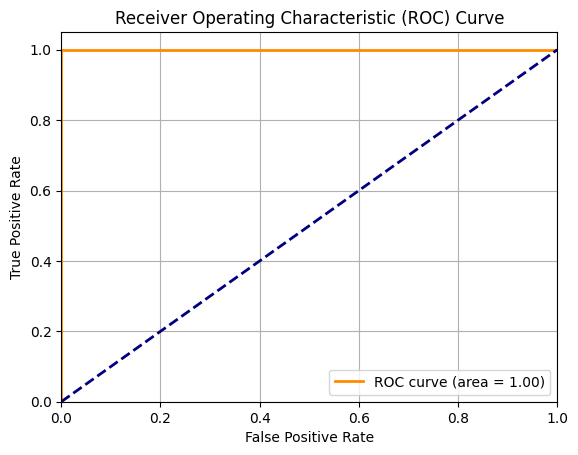

In [30]:
# prompt: dalla pipeline di cui sopra vorrei che facessi calcoli su indici di performance: accuracy, precision, sensitivity, specificity, che facessi una confusion matrix, una ROC e calcolassi Area Under the Curve AUC

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

class PerformanceEvaluator(BaseEstimator, TransformerMixin):
    """
    A custom transformer to evaluate the performance of a classifier
    using various metrics (Accuracy, Precision, Sensitivity, Specificity),
    Confusion Matrix, ROC Curve, and AUC.

    Assumes the input is a tuple containing (trained_model, data_train, data_test),
    where data_test is a pandas DataFrame with features and the target variable
    (last column).
    """
    def __init__(self):
        self.accuracy = None
        self.precision = None
        self.sensitivity = None # Recall
        self.specificity = None
        self.confusion_matrix = None
        self.fpr = None
        self.tpr = None
        self.roc_auc = None

    def fit(self, X, y=None):
        """
        Evaluates the model performance on the test set.

        Args:
            X: A tuple containing (..., trained_model, data_train, data_test).
               data_test is a pandas DataFrame where the last column is the target.
               We only need the trained_model and data_test from the input tuple.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) < 3:
            # We expect the input to have at least the model, train, and test data
            raise TypeError("Input X must be a tuple containing at least (..., trained_model, data_train, data_test).")

        # Extract the necessary elements from the input tuple
        # Assuming the last three elements are trained_model, data_train, data_test
        trained_model = X[-3]
        # data_train = X[-2] # Not needed for test set evaluation
        data_test = X[-1]

        if not isinstance(data_test, pd.DataFrame):
             raise TypeError("The last element in the input tuple must be a pandas DataFrame (data_test).")

        # Separate features (X_test) and true target (y_test) from data_test
        X_test = data_test.iloc[:, :-1]
        y_test = data_test.iloc[:, -1]

        print("\nEvaluating model performance on the test set...")

        # Make predictions on the test set
        y_pred = trained_model.predict(X_test)

        # Calculate performance metrics
        self.accuracy = accuracy_score(y_test, y_pred)
        self.precision = precision_score(y_test, y_pred)
        self.sensitivity = recall_score(y_test, y_pred) # Sensitivity is the same as Recall

        # Calculate Specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        self.specificity = tn / (tn + fp)

        print(f"Accuracy: {self.accuracy:.4f}")
        print(f"Precision: {self.precision:.4f}")
        print(f"Sensitivity (Recall): {self.sensitivity:.4f}")
        print(f"Specificity: {self.specificity:.4f}")

        # Calculate Confusion Matrix
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(self.confusion_matrix)

        # Calculate ROC Curve and AUC
        # Need predicted probabilities for ROC curve
        if hasattr(trained_model, "predict_proba"):
            y_prob = trained_model.predict_proba(X_test)[:, 1] # Probability of the positive class
            self.fpr, self.tpr, thresholds = roc_curve(y_test, y_prob)
            self.roc_auc = auc(self.fpr, self.tpr)
            print(f"\nROC AUC: {self.roc_auc:.4f}")
        else:
            print("\nModel does not have predict_proba method. Cannot compute ROC/AUC.")
            self.fpr, self.tpr, self.roc_auc = None, None, None


        return self

    def transform(self, X):
        """
        Returns the calculated performance metrics and results.

        Args:
            X: Input data (ignored, evaluation is done in fit).

        Returns:
            tuple: A tuple containing the evaluation results
                   (accuracy, precision, sensitivity, specificity,
                    confusion_matrix, fpr, tpr, roc_auc)
                    along with the original input tuple elements for
                    potential subsequent steps.
        """
        # Return the computed results and the original input tuple elements
        # This allows subsequent steps (if any) to access prior results
        return (self.accuracy, self.precision, self.sensitivity, self.specificity,
                self.confusion_matrix, self.fpr, self.tpr, self.roc_auc) + X


# Extend the existing pipeline to include the PerformanceEvaluator
pipeline_with_evaluation = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer()),
    ('cross_validate_decision_tree', DecisionTreeCrossValidator(n_splits=5, random_state=42)),
    ('evaluate_performance', PerformanceEvaluator()) # Add the evaluator
])

# Apply pipeline
trained_model_evaluated = pipeline_with_evaluation.fit_transform((data_train, data_test))

# Access the evaluation results
accuracy, precision, sensitivity, specificity, cm, fpr, tpr, roc_auc = trained_model_evaluated[:8]
# You can also access other outputs from previous steps if needed:
# cv_scores, trained_dt_model, scaled_data_train, scaled_data_test = trained_model_evaluated[8:]


print("\nPerformance Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nConfusion Matrix:")
print(cm)
if roc_auc is not None:
    print(f"ROC AUC: {roc_auc:.4f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("\nROC curve and AUC were not plotted as predict_proba was not available.")
